In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 100

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/10, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.1):
        for j in np.arange(0, 10, 0.1):
            psiExato[r][int(j*10)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((500,500))
    B = np.zeros((500,500))
    A = multMatrizes(M = 500, us = x[0])
    B = multMatrizes(M = 500, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:500, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)

In [6]:
import random

psi = np.zeros((500,500))
psi_f = np.zeros((500,500))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)

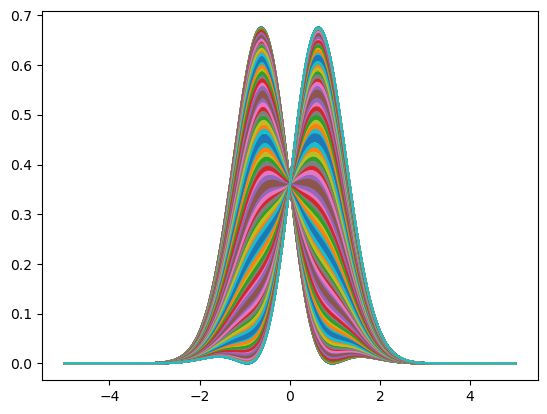

In [7]:
xs = np.linspace(-5,5,500)
plt.plot(xs, np.absolute(psi[0:500,0:500])**2)

[-4.308515866729441, -1.4474110839051924]
Iteração: 1
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 85892.1467063009
       x: [-3.897e+02  3.217e+01]
     nit: 12
     jac: [ 9.766e-04  0.000e+00]
    nfev: 218
    njev: 69
---------------
[-389.7152605184998, 3.065389177532042]
Iteração: 2
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 82400.57628861172
       x: [ 3.218e+01  3.372e+01]
     nit: 16
     jac: [ 1.953e-03  0.000e+00]
    nfev: 159
    njev: 53
---------------
[32.177491299741014, -3.643300315710839]
Iteração: 3
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81988.77001880144
       x: [ 3.371e+01  3.463e+01]
     nit: 13
     jac: [ 0.000e+00  0.000e+00]
    nfev: 135
    njev: 45
---------------
[33.708248672275516, -2.7092576224610756]
Iteração: 4
 message: Optimization terminated successfully.
 success:

Iteração: 30
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 83620.72661360417
       x: [ 2.969e+01  2.574e+01]
     nit: 11
     jac: [ 1.953e-03  9.766e-04]
    nfev: 261
    njev: 83
---------------
[29.691560243635436, -0.312236292162015]
Iteração: 31
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 84368.24333152338
       x: [ 2.569e+01  1.935e+01]
     nit: 8
     jac: [-3.906e-03  0.000e+00]
    nfev: 116
    njev: 35
---------------
[25.69368581491344, 2.0266868075174873]
Iteração: 32
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 85136.78769229028
       x: [ 1.941e+01  9.388e+00]
     nit: 6
     jac: [ 9.766e-04  0.000e+00]
    nfev: 164
    njev: 51
---------------
[19.40938972805922, -2.3120284580952744]
Iteração: 33
 message: Optimization terminated successfully.
 success: True
  status:

Iteração: 58
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 85137.07441193354
       x: [ 9.436e+00  1.933e+01]
     nit: 5
     jac: [ 2.930e-03  1.953e-03]
    nfev: 156
    njev: 48
---------------
[9.435994271701581, -3.6740132698546626]
Iteração: 59
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84368.8626613259
       x: [ 1.938e+01  2.566e+01]
     nit: 8
     jac: [ 0.000e+00  0.000e+00]
    nfev: 72
    njev: 24
---------------
[19.383369644166997, 4.566995697151361]
Iteração: 60
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 83621.61383844662
       x: [ 2.568e+01  2.964e+01]
     nit: 7
     jac: [ 1.953e-03 -9.766e-04]
    nfev: 170
    njev: 53
---------------
[25.6787108889923, -2.9544184139003082]
Iteração: 61
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
 

Iteração: 86
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 81733.04277944381
       x: [ 3.502e+01  3.462e+01]
     nit: 10
     jac: [ 1.953e-03 -9.766e-04]
    nfev: 99
    njev: 33
---------------
[35.02155266152323, 3.806054984145689]
Iteração: 87
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81986.63322764855
       x: [ 3.463e+01  3.372e+01]
     nit: 13
     jac: [ 0.000e+00  0.000e+00]
    nfev: 186
    njev: 62
---------------
[34.629246267622506, -3.882252878887571]
Iteração: 88
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82398.54417763263
       x: [ 3.375e+01  3.211e+01]
     nit: 9
     jac: [ 0.000e+00  0.000e+00]
    nfev: 69
    njev: 23
---------------
[33.74863387229852, -4.186510943103956]
Iteração: 89
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82951.91932479819
       x: [ 3.213e+01 

Iteração: 114
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799643
       x: [ 1.938e+01 -2.208e+00]
     nit: 2
     jac: [ 5.859e-03  0.000e+00]
    nfev: 57
    njev: 19
---------------
[19.38182242639429, -4.375500309476786]
Iteração: 115
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799654
       x: [ 1.938e+01 -4.376e+00]
     nit: 0
     jac: [-3.906e-03 -1.953e-03]
    nfev: 116
    njev: 35
---------------
[19.38182242639429, 3.4706736440920576]
Iteração: 116
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799652
       x: [ 1.938e+01  3.471e+00]
     nit: 0
     jac: [ 3.906e-03  9.766e-04]
    nfev: 116
    njev: 35
---------------
[19.38182242639429, -0.7258753191471454]
Iteração: 117
 message: Desired error not necessarily achieved due to precision loss.

Iteração: 141
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799713
       x: [ 1.938e+01 -3.083e+00]
     nit: 1
     jac: [-3.906e-03  0.000e+00]
    nfev: 42
    njev: 14
---------------
[19.381854947498763, -3.274654376619661]
Iteração: 142
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.9999979971
       x: [ 1.938e+01 -3.275e+00]
     nit: 1
     jac: [ 4.883e-03  2.930e-03]
    nfev: 139
    njev: 43
---------------
[19.38188206591378, -4.875860675233189]
Iteração: 143
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999799716
       x: [ 1.938e+01 -4.876e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00]
    nfev: 60
    njev: 20
---------------
[19.38188203626944, 1.5246928019232442]
Iteração: 144
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 

Iteração: 169
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799771
       x: [ 1.938e+01  1.280e+00]
     nit: 2
     jac: [ 4.883e-03  0.000e+00]
    nfev: 218
    njev: 69
---------------
[19.381599120896507, 2.5703117183714603]
Iteração: 170
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799771
       x: [ 1.938e+01  2.571e+00]
     nit: 1
     jac: [ 1.953e-03  0.000e+00]
    nfev: 164
    njev: 51
---------------
[19.381599120896507, 1.7704275703986436]
Iteração: 171
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799776
       x: [ 1.938e+01  1.770e+00]
     nit: 0
     jac: [ 4.883e-03  0.000e+00]
    nfev: 114
    njev: 34
---------------
[19.381599120896507, -0.1492364984024528]
Iteração: 172
 message: Optimization terminated successfully.
 success: True
  st

Iteração: 197
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799834
       x: [ 1.938e+01 -1.900e-01]
     nit: 1
     jac: [ 4.883e-03  9.766e-04]
    nfev: 174
    njev: 54
---------------
[19.381924953464924, 0.1450347546585391]
Iteração: 198
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799835
       x: [ 1.938e+01  1.450e-01]
     nit: 4
     jac: [ 3.906e-03  9.766e-04]
    nfev: 93
    njev: 31
---------------
[19.38193183471389, 0.5029667316804423]
Iteração: 199
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999799841
       x: [ 1.938e+01  5.030e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 15
    njev: 5
---------------
[19.381983868429288, -2.427461662808917]
Iteração: 200
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status:

Iteração: 225
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799904
       x: [ 1.938e+01 -4.162e+00]
     nit: 0
     jac: [ 9.766e-03  4.883e-03]
    nfev: 159
    njev: 49
---------------
[19.382023298533067, -0.925748315420412]
Iteração: 226
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799908
       x: [ 1.938e+01 -9.256e-01]
     nit: 1
     jac: [ 2.930e-03  0.000e+00]
    nfev: 273
    njev: 86
---------------
[19.382023298533067, -4.769729899904576]
Iteração: 227
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.9999979991
       x: [ 1.938e+01 -4.770e+00]
     nit: 1
     jac: [ 0.000e+00  9.766e-04]
    nfev: 192
    njev: 60
---------------
[19.381848891025147, 3.2888272043576965]
Iteração: 228
 message: Desired error not necessarily achieved due to precision los

Iteração: 253
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999799981
       x: [ 1.938e+01 -2.074e+00]
     nit: 0
     jac: [ 0.000e+00  0.000e+00]
    nfev: 3
    njev: 1
---------------
[19.381877023012, -2.372392870827167]
Iteração: 254
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.9999979998
       x: [ 1.938e+01 -2.372e+00]
     nit: 1
     jac: [-9.766e-04 -9.766e-04]
    nfev: 131
    njev: 41
---------------
[19.38192566893284, 3.8353686784505285]
Iteração: 255
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799978
       x: [ 1.938e+01  3.835e+00]
     nit: 1
     jac: [ 2.930e-03  9.766e-04]
    nfev: 129
    njev: 39
---------------
[19.38185590721289, 2.8422056775098383]
Iteração: 256
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
  

Iteração: 281
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800036
       x: [ 1.938e+01 -3.835e-01]
     nit: 3
     jac: [-9.766e-04 -9.766e-04]
    nfev: 27
    njev: 9
---------------
[19.382005498323462, -2.1651894887096743]
Iteração: 282
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800038
       x: [ 1.938e+01 -2.165e+00]
     nit: 0
     jac: [ 1.953e-03  9.766e-04]
    nfev: 93
    njev: 27
---------------
[19.382005498323462, 2.484559929401483]
Iteração: 283
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800045
       x: [ 1.938e+01  2.485e+00]
     nit: 0
     jac: [ 9.766e-04  0.000e+00]
    nfev: 106
    njev: 32
---------------
[19.382005498323462, -0.6640262155725267]
Iteração: 284
 message: Desired error not necessarily achieved due to precision loss

Iteração: 309
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800119
       x: [ 1.938e+01 -2.370e+00]
     nit: 0
     jac: [ 2.930e-03  2.930e-03]
    nfev: 138
    njev: 42
---------------
[19.382242588962026, 2.8299769315906973]
Iteração: 310
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800124
       x: [ 1.938e+01  2.830e+00]
     nit: 2
     jac: [ 1.953e-03  0.000e+00]
    nfev: 246
    njev: 75
---------------
[19.38224397760469, 1.4343092753276308]
Iteração: 311
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800128
       x: [ 1.938e+01  1.434e+00]
     nit: 1
     jac: [-1.953e-03  2.930e-03]
    nfev: 103
    njev: 31
---------------
[19.382306081171542, 0.8722484079607007]
Iteração: 312
 message: Desired error not necessarily achieved due to precision los

Iteração: 337
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800183
       x: [ 1.938e+01 -3.009e+00]
     nit: 1
     jac: [ 9.766e-04  9.766e-04]
    nfev: 24
    njev: 8
---------------
[19.38255261633113, 2.3320274520698607]
Iteração: 338
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800185
       x: [ 1.938e+01  2.332e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 12
    njev: 4
---------------
[19.382674133789543, -3.6024301012353077]
Iteração: 339
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800188
       x: [ 1.938e+01 -3.602e+00]
     nit: 1
     jac: [ 9.766e-04  9.766e-04]
    nfev: 184
    njev: 56
---------------
[19.38271319770615, -0.3173512548561499]
Iteração: 340
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.999998

Iteração: 365
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800255
       x: [ 1.938e+01 -3.865e+00]
     nit: 0
     jac: [ 0.000e+00 -9.766e-04]
    nfev: 144
    njev: 44
---------------
[19.383131720748736, 1.0556401605570667]
Iteração: 366
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800256
       x: [ 1.938e+01  1.056e+00]
     nit: 2
     jac: [ 0.000e+00  9.766e-04]
    nfev: 42
    njev: 14
---------------
[19.383235322646847, 0.5916776475092487]
Iteração: 367
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800256
       x: [ 1.938e+01  5.917e-01]
     nit: 1
     jac: [-9.766e-04 -9.766e-04]
    nfev: 197
    njev: 60
---------------
[19.38322838124256, -2.0150001290894526]
Iteração: 368
 message: Desired error not necessarily achieved due to precision los

Iteração: 393
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800323
       x: [ 1.938e+01 -3.165e-01]
     nit: 0
     jac: [ 9.766e-04  9.766e-04]
    nfev: 113
    njev: 34
---------------
[19.383751588462548, -1.9720719469570236]
Iteração: 394
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800324
       x: [ 1.938e+01 -1.972e+00]
     nit: 0
     jac: [-1.953e-03  9.766e-04]
    nfev: 110
    njev: 33
---------------
[19.383751588462548, -0.9707861247980256]
Iteração: 395
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800327
       x: [ 1.938e+01 -9.708e-01]
     nit: 1
     jac: [-9.766e-04  0.000e+00]
    nfev: 36
    njev: 12
---------------
[19.3837393654953, 2.9276035782305385]
Iteração: 396
 message: Optimization terminated successfully.
 success: True
  stat

Iteração: 421
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800394
       x: [ 1.938e+01 -3.041e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 48
    njev: 16
---------------
[19.383340671257365, 3.973014540564769]
Iteração: 422
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800399
       x: [ 1.938e+01  3.973e+00]
     nit: 1
     jac: [-1.953e-03  0.000e+00]
    nfev: 215
    njev: 68
---------------
[19.38337973953396, 3.254685732736416]
Iteração: 423
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.999998004
       x: [ 1.938e+01  3.255e+00]
     nit: 0
     jac: [ 1.953e-03  9.766e-04]
    nfev: 128
    njev: 39
---------------
[19.38337973953396, -0.21695613947834147]
Iteração: 424
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 

Iteração: 449
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800458
       x: [ 1.938e+01 -3.131e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00]
    nfev: 121
    njev: 38
---------------
[19.38317722617617, -0.2656448097231472]
Iteração: 450
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800457
       x: [ 1.938e+01 -2.656e-01]
     nit: 0
     jac: [ 9.766e-04  0.000e+00]
    nfev: 122
    njev: 37
---------------
[19.38317722617617, 1.5206775791009877]
Iteração: 451
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800458
       x: [ 1.938e+01  1.521e+00]
     nit: 0
     jac: [ 1.953e-03  2.930e-03]
    nfev: 47
    njev: 12
---------------
[19.38317722617617, 2.488807628248571]
Iteração: 452
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.999998

Iteração: 477
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800524
       x: [ 1.938e+01 -1.697e+00]
     nit: 1
     jac: [ 0.000e+00  9.766e-04]
    nfev: 84
    njev: 28
---------------
[19.383633174159254, -2.3135489744814985]
Iteração: 478
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800525
       x: [ 1.938e+01 -2.314e+00]
     nit: 1
     jac: [ 1.953e-03  1.953e-03]
    nfev: 119
    njev: 37
---------------
[19.383691066568225, -4.580630800502665]
Iteração: 479
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800534
       x: [ 1.938e+01 -4.581e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 36
    njev: 12
---------------
[19.38376372655814, 2.9085837492649453]
Iteração: 480
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  statu

NameError: name 'tempoIncial' is not defined

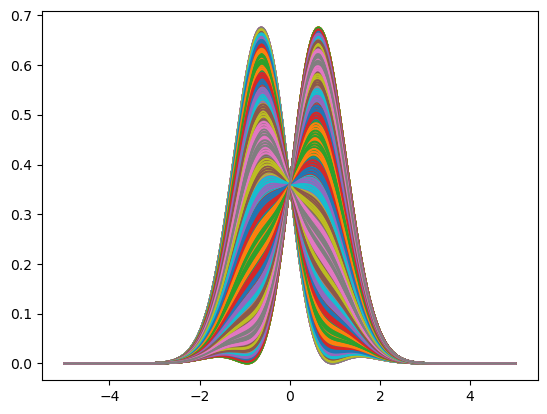

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,500)
minimo = np.zeros((1, 500)).astype(complex)

while tempo < 498:
    print(u1)
    psi_g[0:500, tempo] = psi[0:500, tempo]
    plt.plot(xs, np.absolute(psi[0:500, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 500, us = u2.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

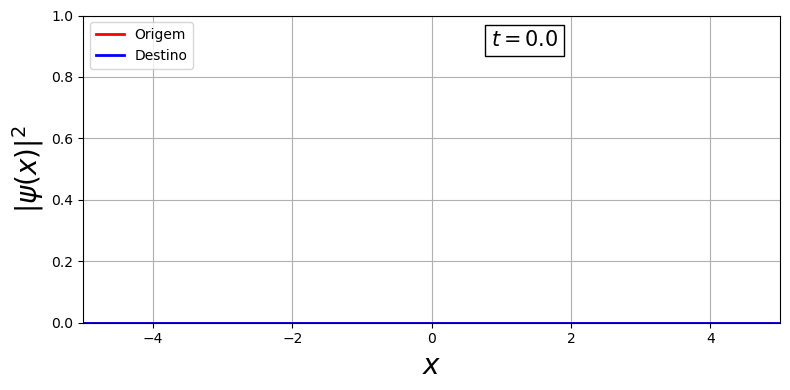

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,500)
    ln1.set_data(xs, np.absolute(psi_g[0:500,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:500,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=500, interval=200)
ani.save('500x500.gif',writer='pillow',fps=10,dpi=100)